In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import itertools

import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
results = pd.read_csv("metrics.csv")

dataf = results[results["algo"] == "datafly"]
mondr = results[results["algo"] == "mondrian"]
dataf_shuff = results[results["algo"] == "datafly_shuffled"]

In [3]:
results

,algo,no,precision,dm,cm,entropy,discern,ilm,auroc,lr_acc,hellinger,bivariate_corr
0,datafly,1,0.184196,0.067073,0.248922,0.882860,0.279394,0.058538,0.768799,0.696503,0.443068,0.256469
1,datafly_shuffled,1,0.217921,0.085366,0.240634,0.813822,0.127674,0.056074,NaN,0.361346,0.395327,0.327287
2,mondrian,1,0.551444,0.817073,0.161296,0.429300,0.000632,0.050426,NaN,0.610641,0.451907,0.014277
3,datafly,2,0.167015,0.079268,0.248922,0.925670,0.436592,0.066250,0.639221,0.544339,0.463347,0.006995
4,datafly_shuffled,2,0.210820,0.067073,0.248922,0.860101,0.231081,0.058820,NaN,0.399967,0.443068,0.000108
...,...,...,...,...,...,...,...,...,...,...,...,...
595,datafly_shuffled,199,0.240942,0.140244,0.243353,0.777514,0.073246,0.056830,NaN,0.554119,0.443068,0.004344
596,mondrian,199,0.553054,0.884146,0.158544,0.493906,0.001710,0.050705,NaN,0.795956,0.438494,0.016014
597,datafly,200,0.242756,0.079268,0.206750,0.910911,0.385237,0.055366,0.670638,0.785182,0.395327,0.249884
598,datafly_shuffled,200,0.168498,0.073171,0.248922,0.897395,0.292923,0.063834,NaN,0.693519,0.438883,0.326455


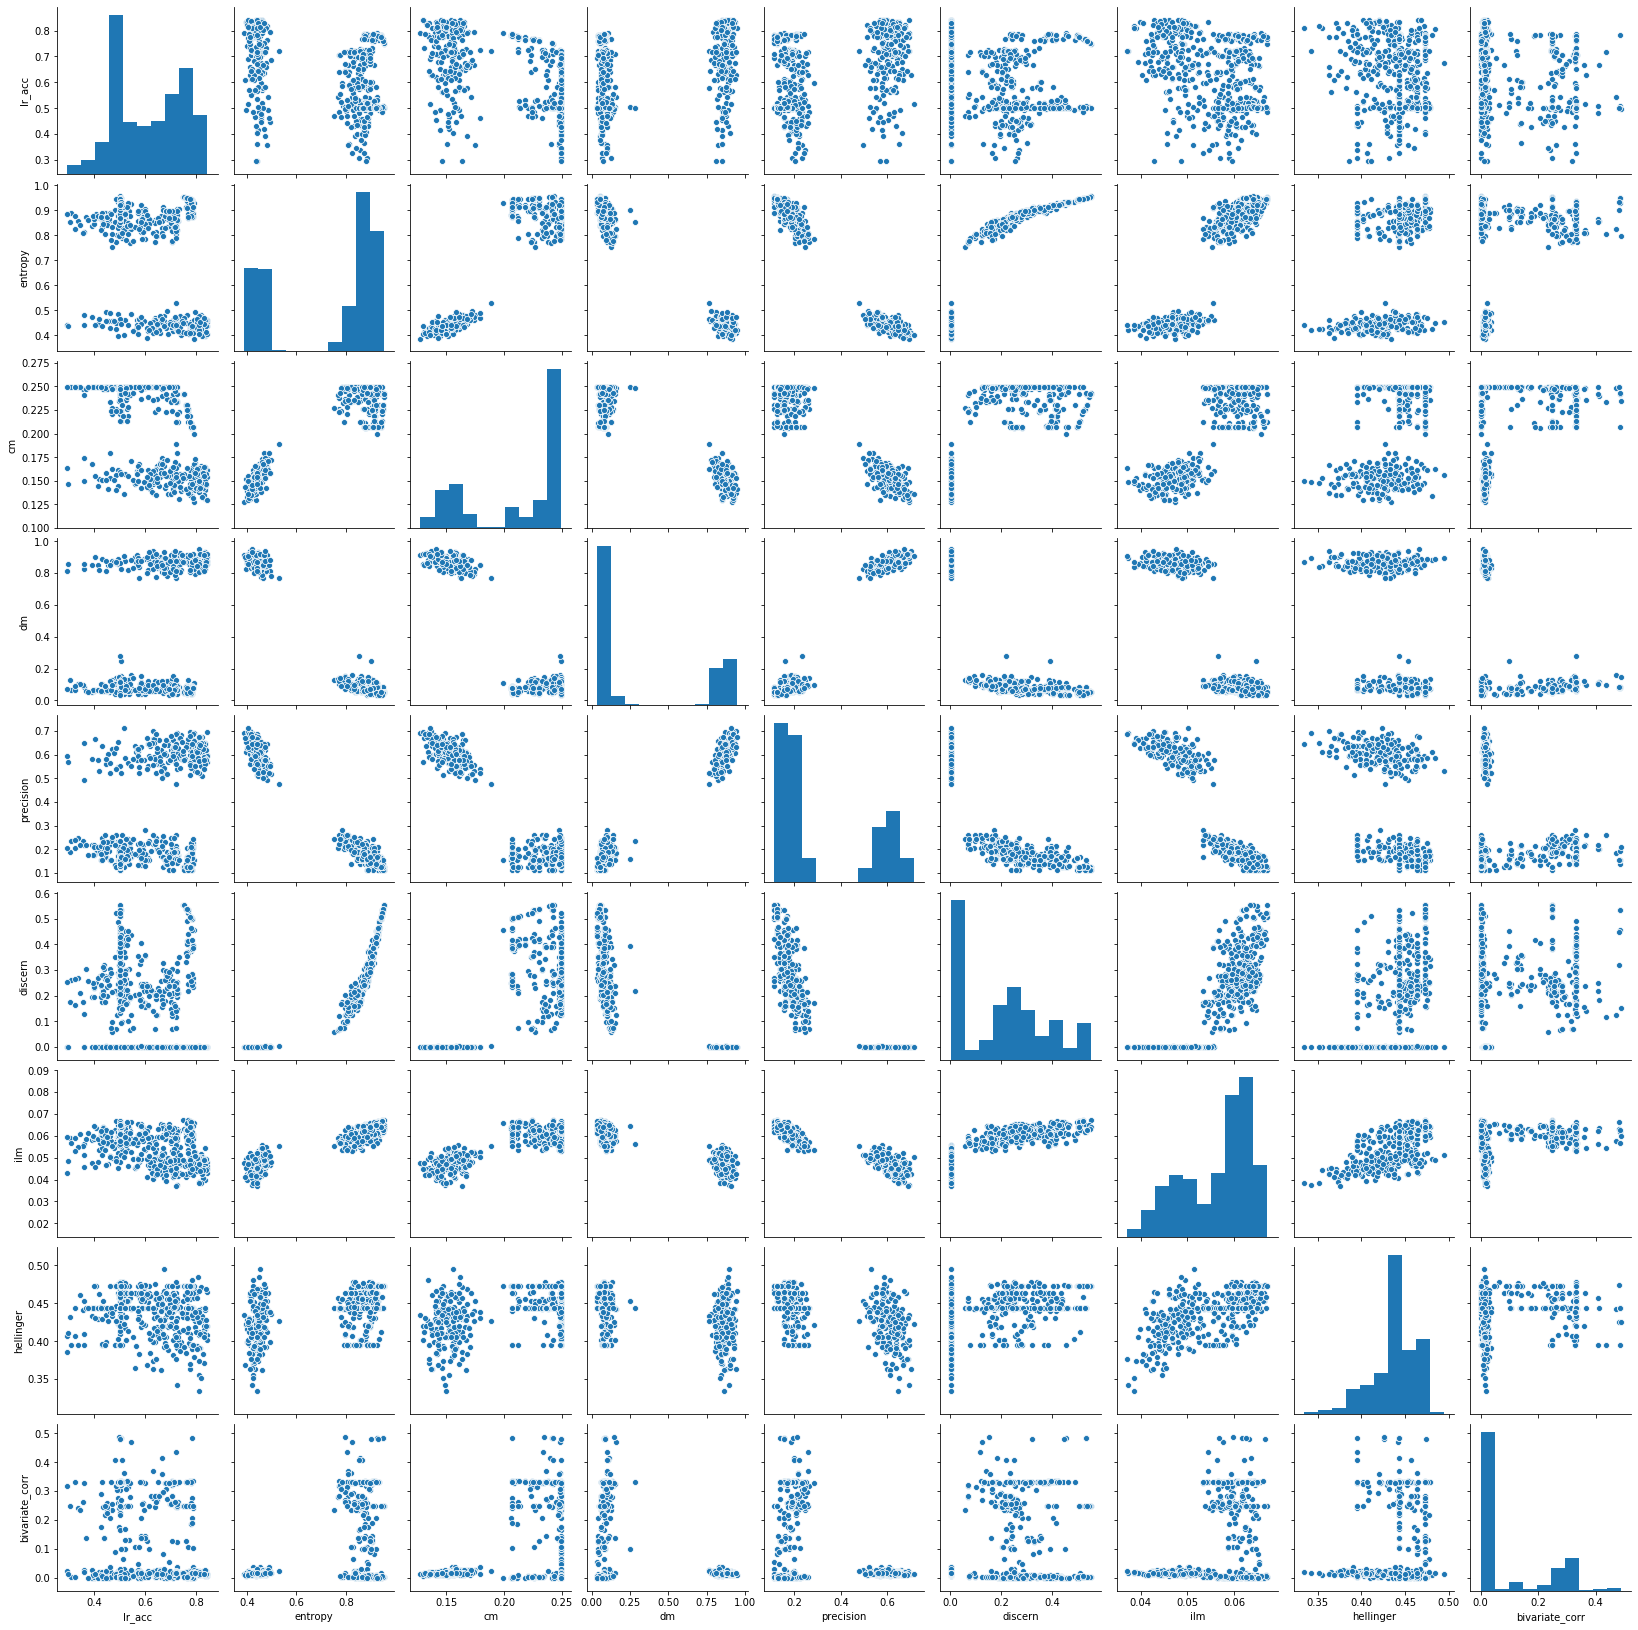

In [4]:
sb.pairplot(results[["lr_acc", "entropy", "cm", "dm", "precision", "discern", "ilm", "hellinger", "bivariate_corr"]])

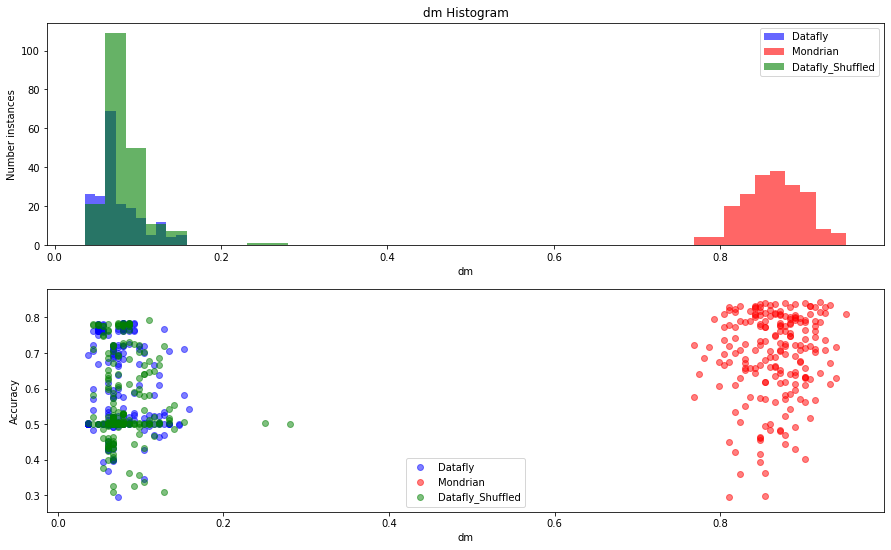

In [6]:
def plot_metric(metric):    
    fig, (ax1, ax2)= plt.subplots(2,1, figsize=(15,9))
    dataflys = results[results["algo"] == "datafly"]
    dataflys_shuff = results[results["algo"] == "datafly_shuffled"]
    mondrians = results[results["algo"] == "mondrian"]
    
    ax1.hist(dataflys[metric], label="Datafly", color="b", alpha=.6)
    ax1.hist(mondrians[metric], label="Mondrian", color="r", alpha=.6)
    ax1.hist(dataflys_shuff[metric], label="Datafly_Shuffled", color="g", alpha=.6)
    ax1.set_xlabel(metric)
    ax1.set_ylabel("Number instances")
    ax1.legend()
    ax1.set_title(f"{metric} Histogram")
    
    ax2.scatter(dataflys[metric], dataflys["lr_acc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["lr_acc"], c="r", alpha=0.5, label="Mondrian")
    ax2.scatter(dataflys_shuff[metric], dataflys_shuff["lr_acc"], c="g", alpha=0.5, label="Datafly_Shuffled")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    
plot_metric("dm")

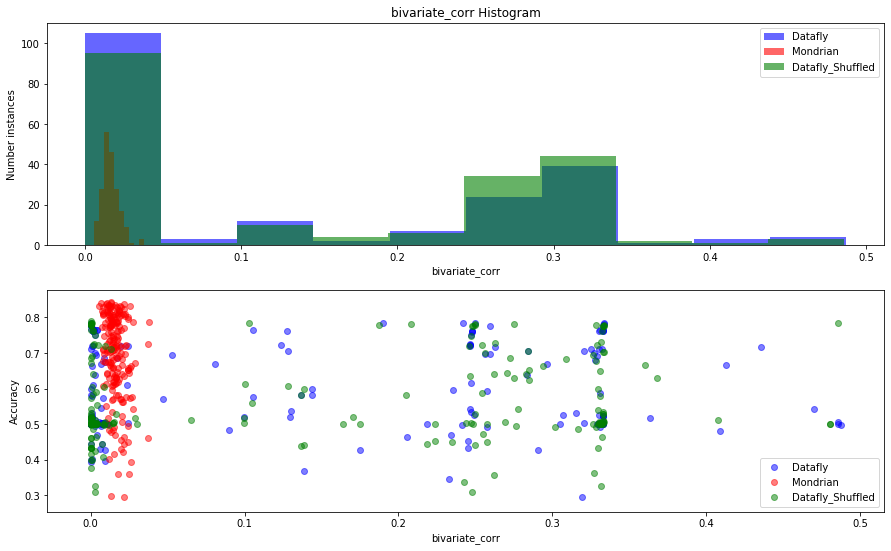

In [7]:
plot_metric("bivariate_corr")

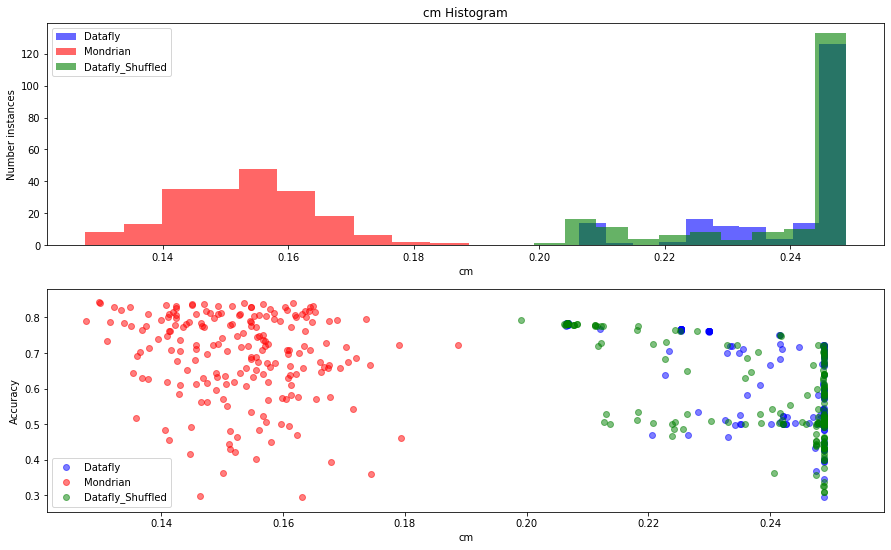

In [6]:
plot_metric("cm")

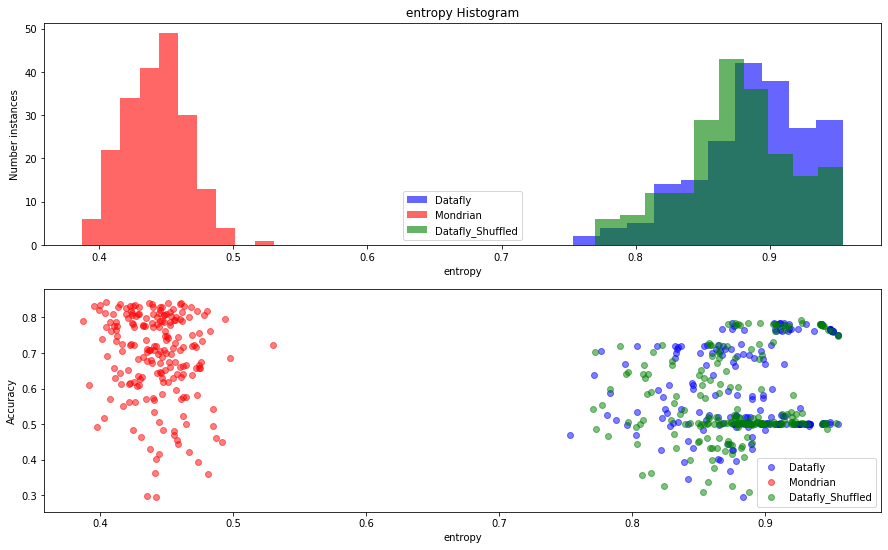

In [7]:
plot_metric("entropy")

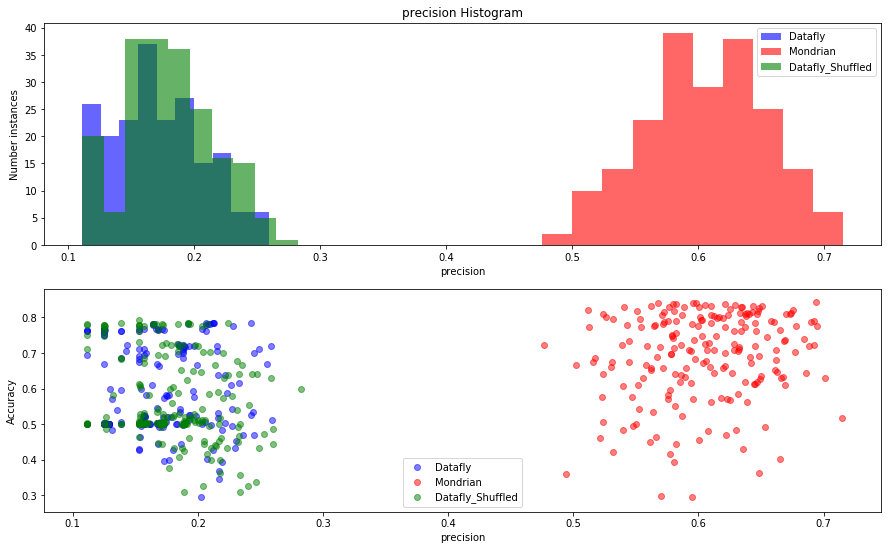

In [8]:
plot_metric("precision")

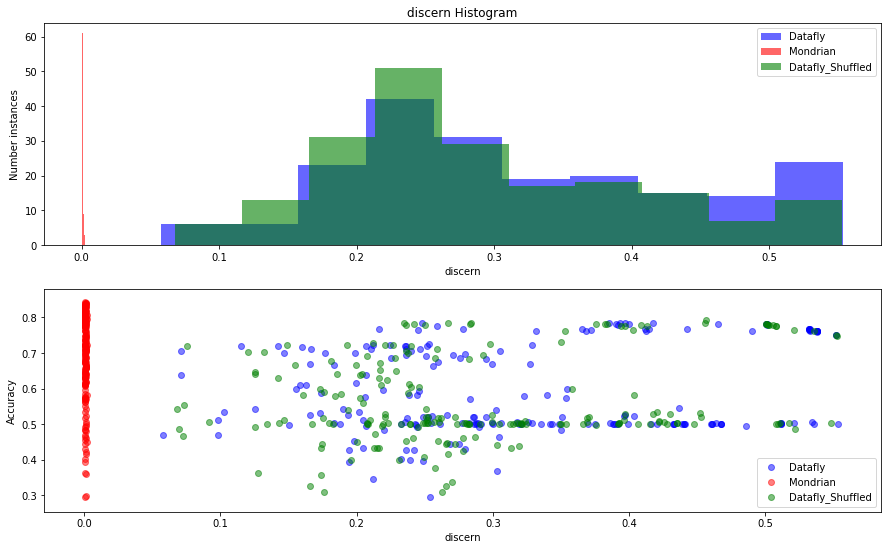

In [9]:
plot_metric("discern")

In [10]:
mondr["discern"].value_counts()

0.000870    1
0.000595    1
0.000707    1
0.000775    1
0.000633    1
           ..
0.000609    1
0.000675    1
0.000616    1
0.001090    1
0.001135    1
Name: discern, Length: 200, dtype: int64

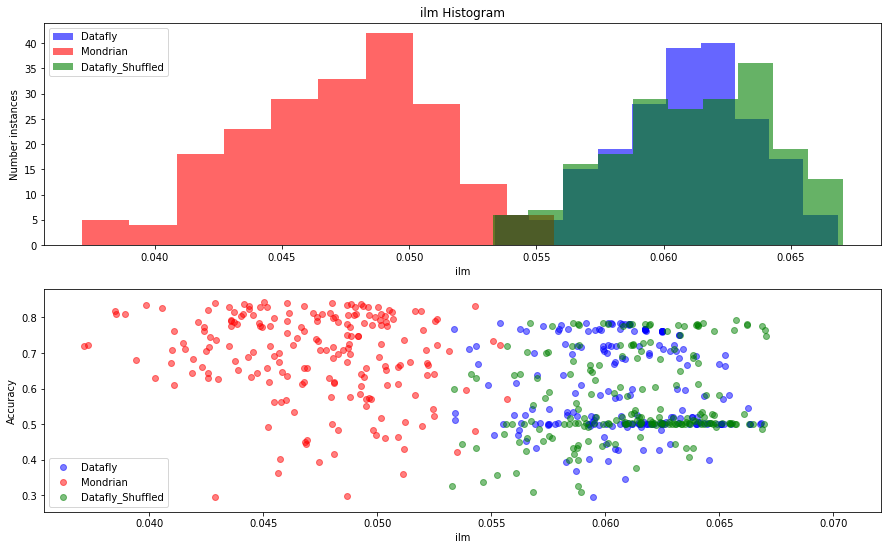

In [11]:
plot_metric("ilm")

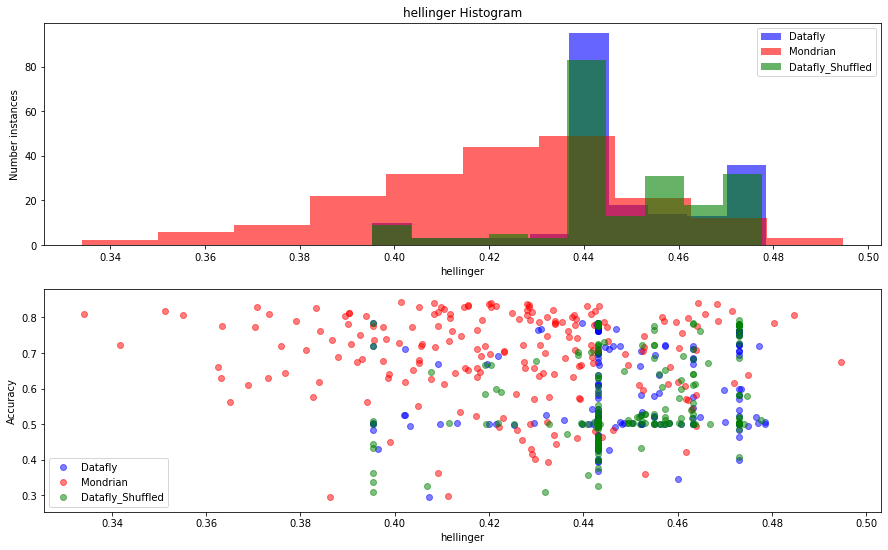

In [27]:
plot_metric("hellinger")

# Plot AUROC

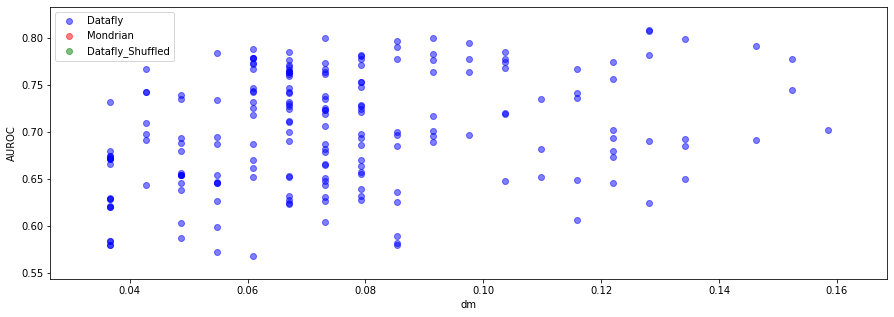

In [12]:
def plot_metric_auroc(metric):    
    fig, (ax2)= plt.subplots(1,1, figsize=(15,5))
    dataflys = results[results["algo"] == "datafly"]
    dataflys_shuff = results[results["algo"] == "datafly_shuffled"]
    mondrians = results[results["algo"] == "mondrian"]

    ax2.scatter(dataflys[metric], dataflys["auroc"], c="b", alpha=0.5, label="Datafly")
    ax2.scatter(mondrians[metric], mondrians["auroc"], c="r", alpha=0.5, label="Mondrian")
    ax2.scatter(dataflys_shuff[metric], dataflys_shuff["auroc"], c="g", alpha=0.5, label="Datafly_Shuffled")
    ax2.set_xlabel(metric)
    ax2.set_ylabel("AUROC")
    ax2.legend()
    
plot_metric_auroc("dm")

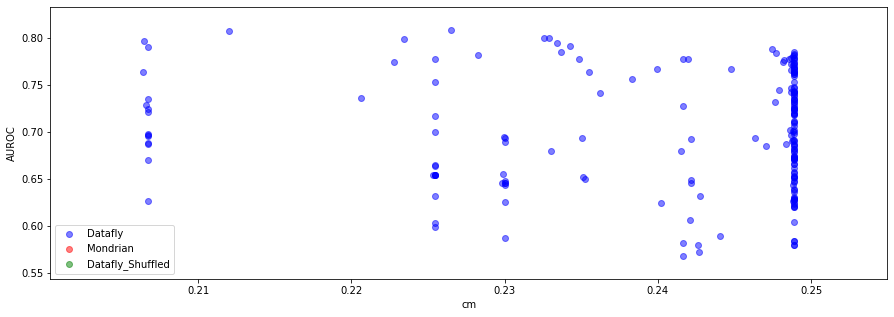

In [13]:
plot_metric_auroc("cm")

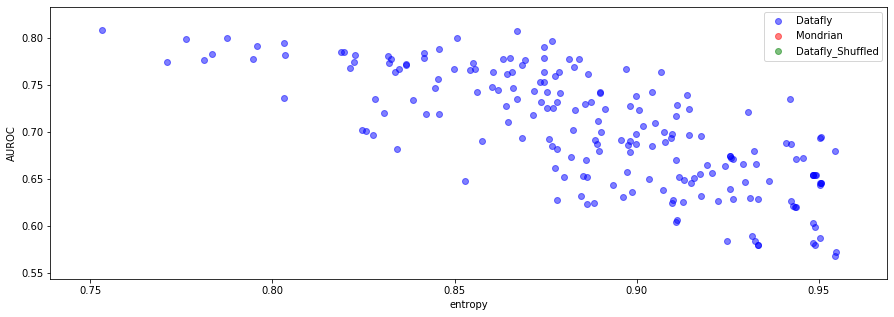

In [14]:
plot_metric_auroc("entropy")

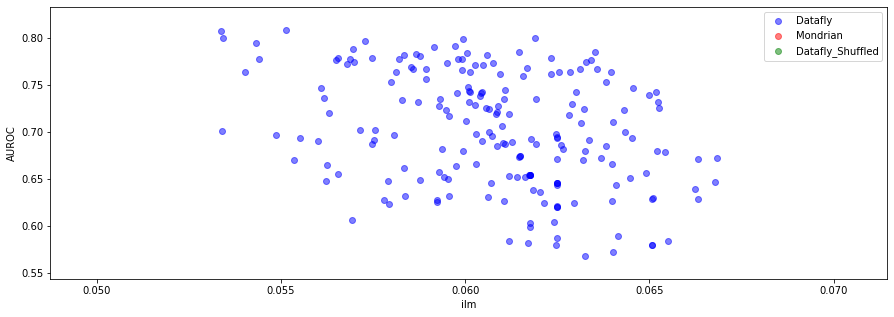

In [15]:
plot_metric_auroc("ilm")

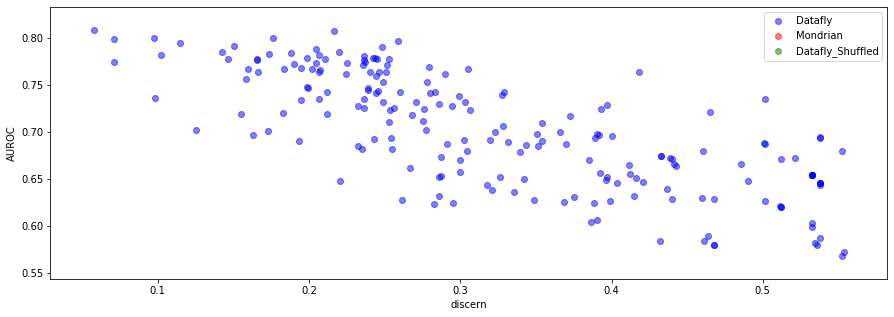

In [16]:
plot_metric_auroc("discern")

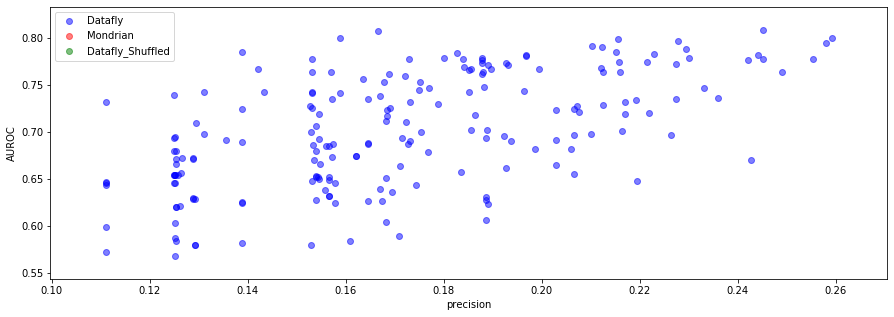

In [17]:
plot_metric_auroc("precision")

# Predicting Power

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def regress(regressor, algo_data):

    X = algo_data[regressor]
    y = algo_data["lr_acc"]

    reg = LinearRegression()
    reg.fit(X, y)

    score = reg.score(X,y)
    return reg, score

def mse(reg, attributes):
    attrs = np.array(results[attributes])
    attrs = attrs.reshape(-1,1) if len(attrs) == 1 else attrs
    y_pred = reg.predict(attrs)
    y_true = results["lr_acc"]
    mse = mean_squared_error(y_true, y_pred)
    return mse

mses = []

In [19]:
def fit_and_graph(regressor, algo_data):
    print(f"Regression on {algo_data['algo'].iloc[0]}")
    reg, score = regress([regressor], algo_data)
    coeff = reg.coef_
    intercept = reg.intercept_
    
    err = mse(reg, [regressor])
    print(f"p-value: {scipy.stats.pearsonr(algo_data[regressor],algo_data['lr_acc'])[1]}")
    print(f"R2 Score: {score}")
    print(f"MSE: {err}")
    print(f"Coeffs: {coeff}")
    print(f"Intercept: {intercept}")
    
    x = np.linspace(0,1,100)
    l = coeff*x + intercept
    
    algo_data.plot.scatter(regressor, "lr_acc", figsize=(15,6), grid=True, 
                           title=f"Linear regression of the {regressor}({algo_data['algo'].iloc[0]})")
            
    plt.plot(x,l)
    


### Entropy

Regression on datafly
p-value: 0.005811058432296975
R2 Score: 0.03778847803886365
MSE: 0.05424775696419808
Coeffs: [0.55107996]
Intercept: 0.10507361668157872

Regression on mondrian
p-value: 0.018526606828008194
R2 Score: 0.027688465098100967
MSE: 0.06956942926718149
Coeffs: [-0.89081417]
Intercept: 1.0865787893458436

Regression on datafly_shuffled
p-value: 0.0026610462654799117
R2 Score: 0.04467417882597725
MSE: 0.06690424252967149
Coeffs: [0.62240743]
Intercept: 0.022191400863196264


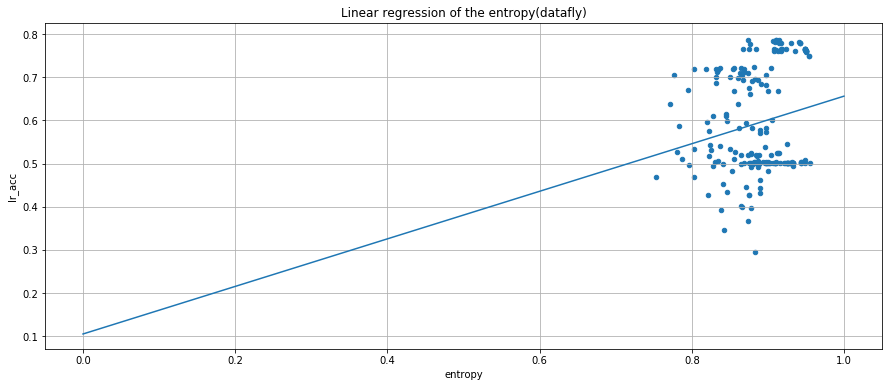

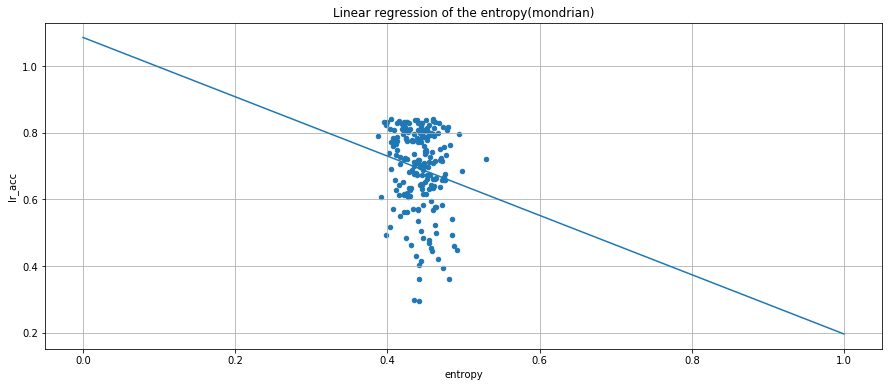

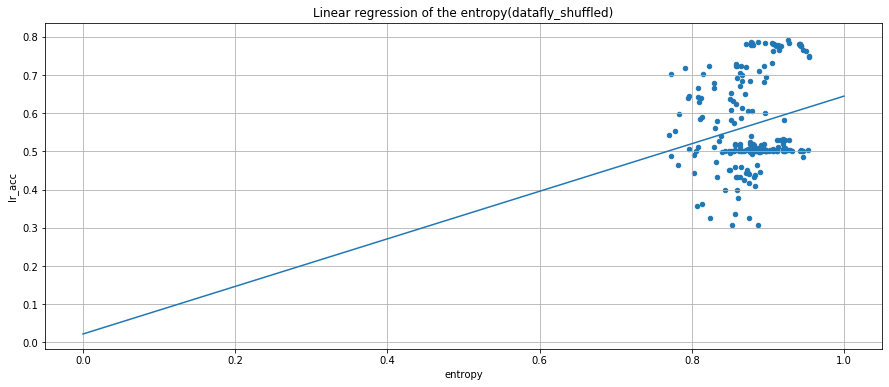

In [20]:
fit_and_graph("entropy", dataf)
print()
fit_and_graph("entropy", mondr)
print()
fit_and_graph("entropy", dataf_shuff)

### Classification Metric

Regression on datafly
p-value: 1.6679784000588354e-26
R2 Score: 0.4371067470525156
MSE: 0.08440709914304666
Coeffs: [-6.41997199]
Intercept: 2.140889208592278

Regression on mondrian
p-value: 0.016317123743348476
R2 Score: 0.028784291252178407
MSE: 0.014893785109862216
Coeffs: [-1.94659965]
Intercept: 0.9900797558858164

Regression on datafly_shuffled
p-value: 2.39977400113731e-25
R2 Score: 0.42184191889415645
MSE: 0.05027441335897757
Coeffs: [-5.37142624]
Intercept: 1.855197213853371


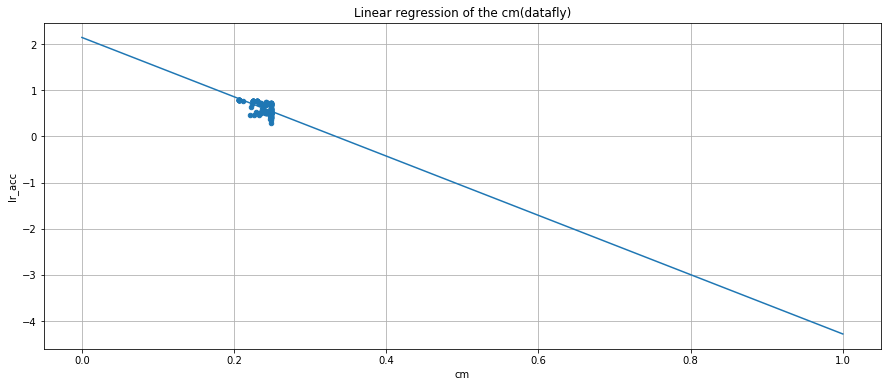

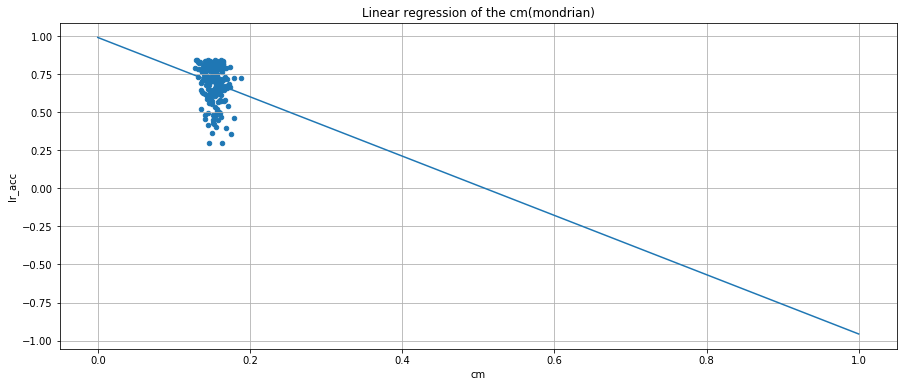

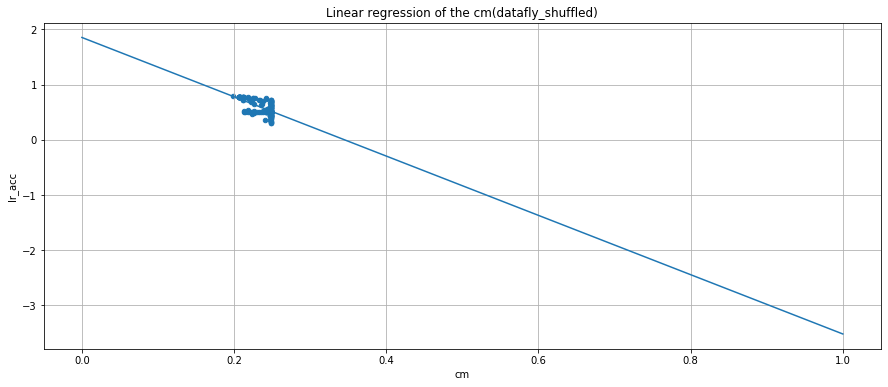

In [21]:
fit_and_graph("cm", dataf)
print()
fit_and_graph("cm", mondr)
print()
fit_and_graph("cm", dataf_shuff)

### DM

Regression on datafly
p-value: 0.4919719852587329
R2 Score: 0.002388074417342012
MSE: 0.03953367680291168
Coeffs: [-0.21756774]
Intercept: 0.6107117902325481

Regression on mondrian
p-value: 0.11193015718282469
R2 Score: 0.012712132343800198
MSE: 0.03724329048793385
Coeffs: [0.37241502]
Intercept: 0.3700852748243817

Regression on datafly_shuffled
p-value: 0.2623015572670993
R2 Score: 0.0063421482358816395
MSE: 0.06551801722580945
Coeffs: [-0.33584597]
Intercept: 0.594910452344894


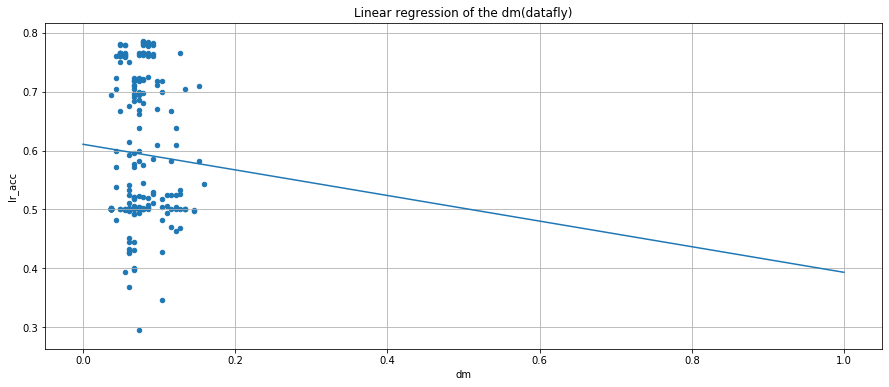

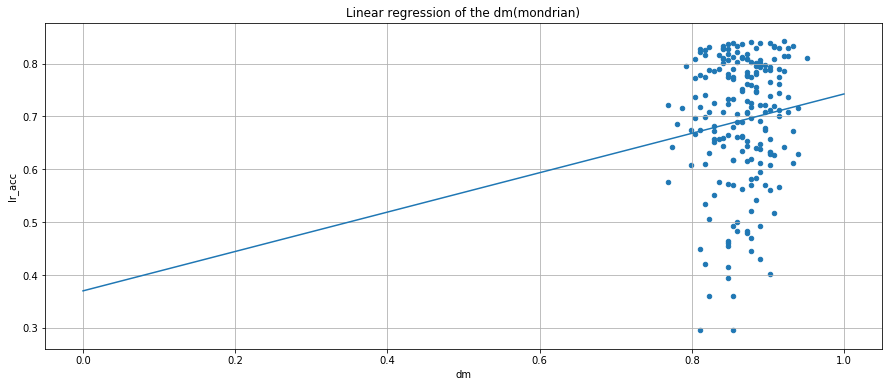

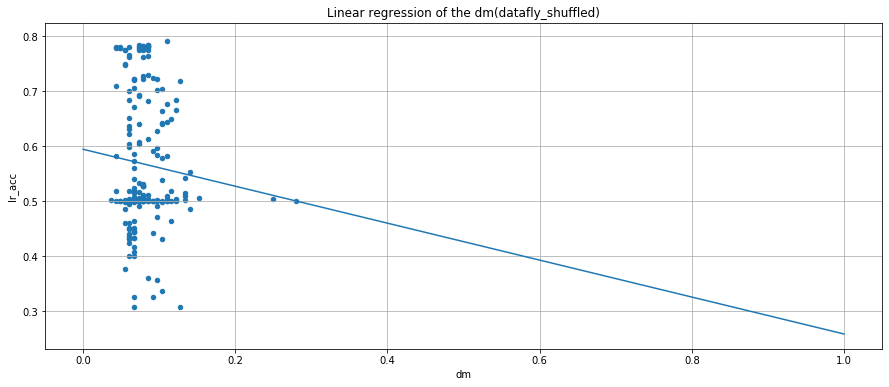

In [22]:
fit_and_graph("dm", dataf)
print()
fit_and_graph("dm", mondr)
print()
fit_and_graph("dm", dataf_shuff)

### Precision


Regression on datafly
p-value: 0.3549004858319734
R2 Score: 0.0043240630836679506
MSE: 0.028100337895867456
Coeffs: [-0.22844561]
Intercept: 0.6335590503135232

Regression on mondrian
p-value: 0.025750275311834072
R2 Score: 0.024863738794155266
MSE: 0.018226257699767857
Coeffs: [0.40927918]
Intercept: 0.44500872115339896

Regression on datafly_shuffled
p-value: 0.00016450916657156713
R2 Score: 0.06936616323895828
MSE: 0.10458396651025657
Coeffs: [-0.92112607]
Intercept: 0.7340038643787202


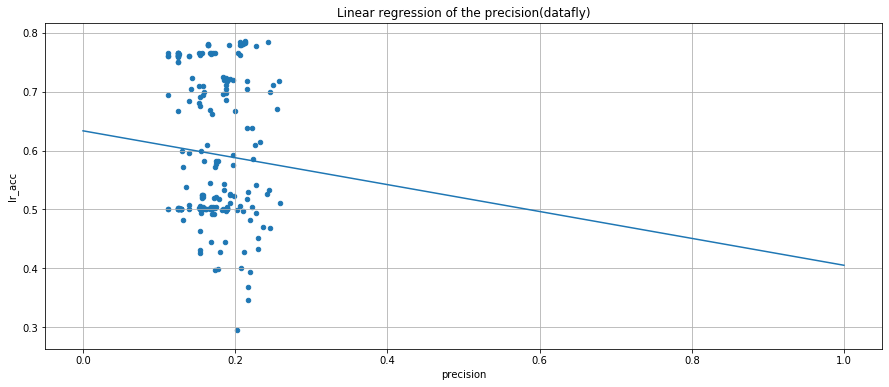

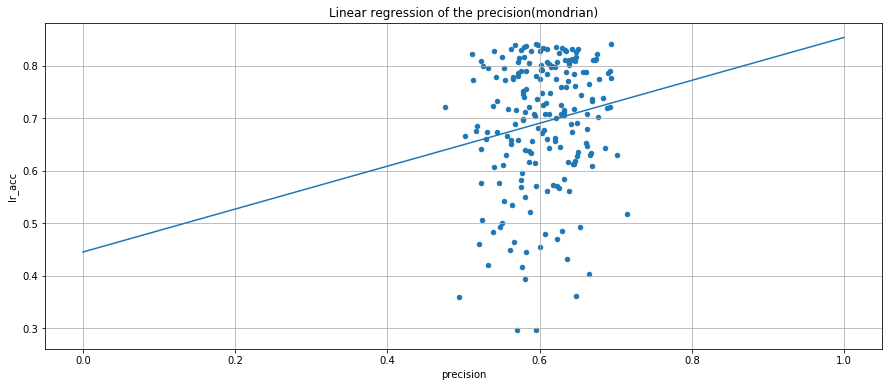

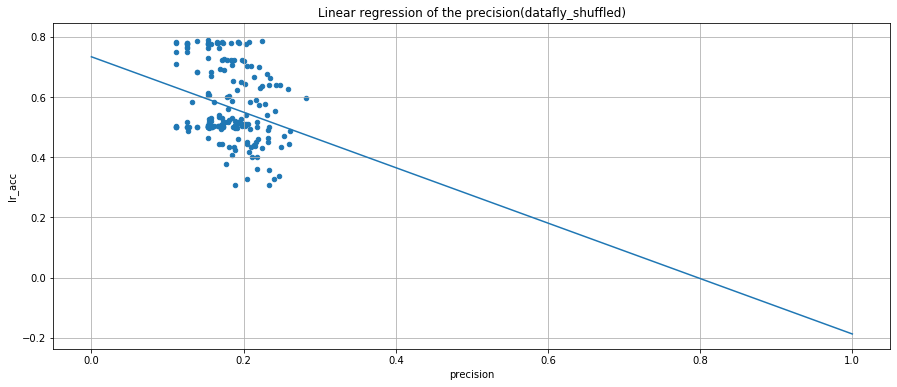

In [23]:
fit_and_graph("precision", dataf)
print()
fit_and_graph("precision", mondr)
print()
fit_and_graph("precision", dataf_shuff)


### Discernability

Regression on datafly
p-value: 0.0019764519164436533
R2 Score: 0.047305996221411746
MSE: 0.023920835901510847
Coeffs: [0.21581482]
Intercept: 0.5248628458828964

Regression on mondrian
p-value: 0.1878616821202588
R2 Score: 0.008742818371337502
MSE: 98.97022241976786
Coeffs: [-37.57933363]
Intercept: 0.7231862331360334

Regression on datafly_shuffled
p-value: 0.0007751555602763174
R2 Score: 0.05560738096413287
MSE: 0.027640326996718964
Coeffs: [0.25507764]
Intercept: 0.4941690174117322


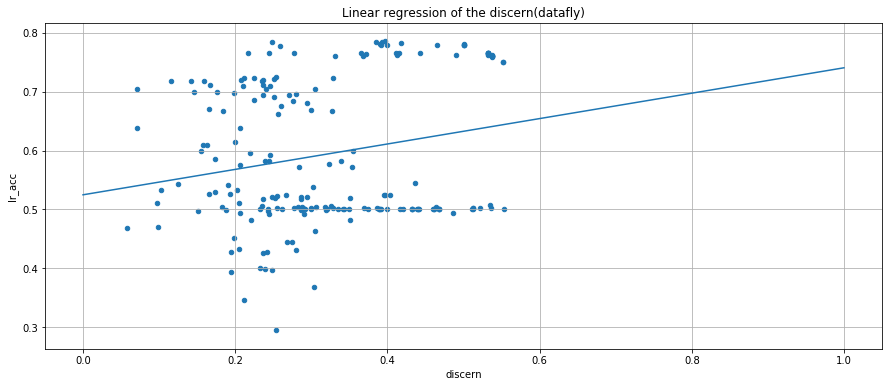

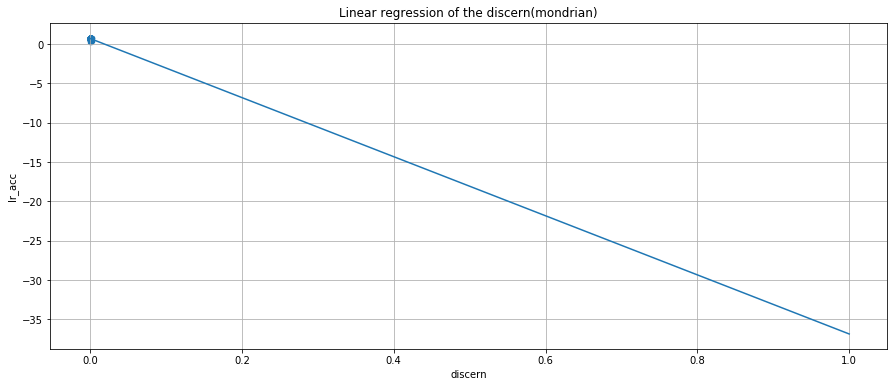

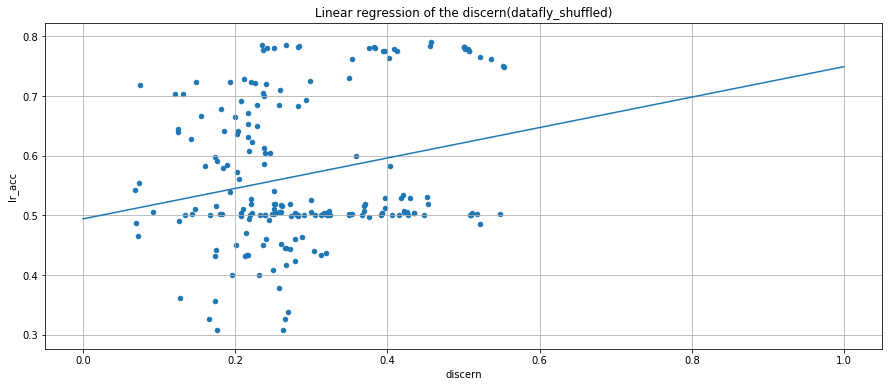

In [24]:
fit_and_graph("discern", dataf)
print()
fit_and_graph("discern", mondr)
print()
fit_and_graph("discern", dataf_shuff)

### Information Loss Metric

Regression on datafly
p-value: 0.19344658365054343
R2 Score: 0.008526295041231147
MSE: 0.015875602164925687
Coeffs: [-3.96113015]
Intercept: 0.8351167845040891

Regression on mondrian
p-value: 0.009028949697088152
R2 Score: 0.033927655673298474
MSE: 0.015776617391091565
Coeffs: [-6.10664854]
Intercept: 0.980952258775841

Regression on datafly_shuffled
p-value: 0.011690290186874269
R2 Score: 0.03167573406703239
MSE: 0.0320483537125434
Coeffs: [6.8433564]
Intercept: 0.14932347127043466


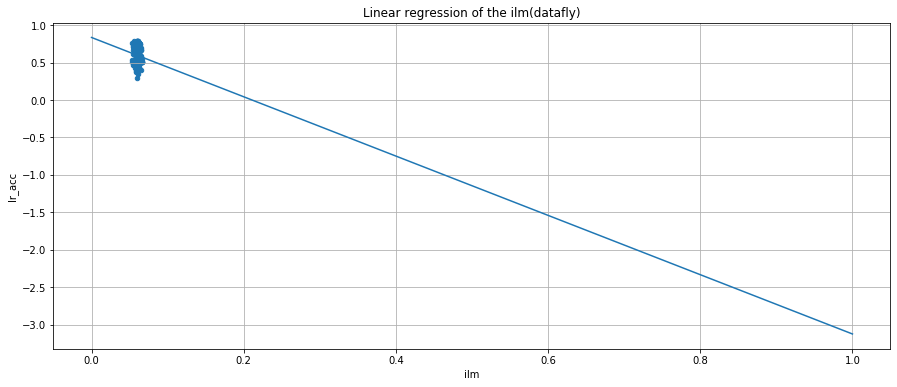

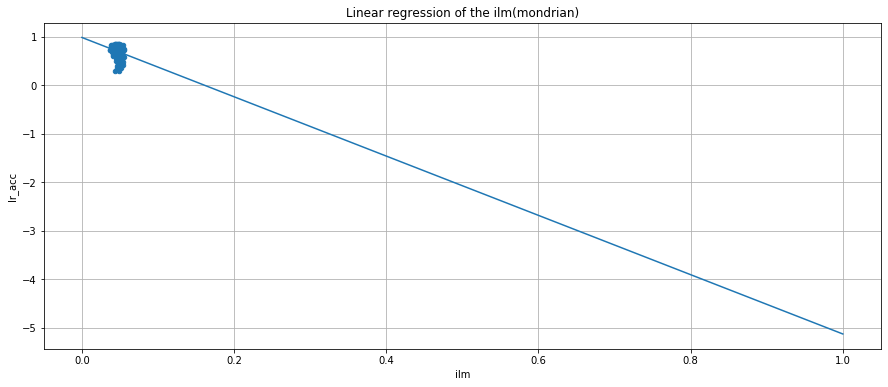

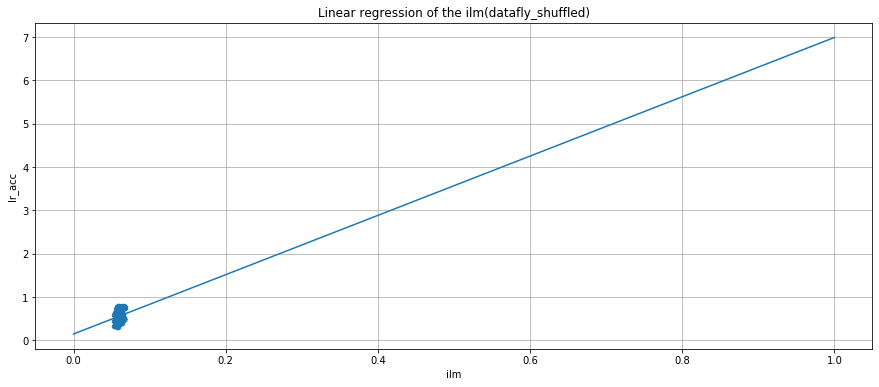

In [25]:
fit_and_graph("ilm", dataf)
print()
fit_and_graph("ilm", mondr)
print()
fit_and_graph("ilm", dataf_shuff)

### Hellinger

Regression on datafly
p-value: 0.1800325530935725
R2 Score: 0.009059202524667964
MSE: 0.019486972721066434
Coeffs: [0.63747819]
Intercept: 0.3088778132760802

Regression on mondrian
p-value: 0.2572246007441041
R2 Score: 0.006478303422749132
MSE: 0.02230386994697596
Coeffs: [-0.34447598]
Intercept: 0.8380484773612976

Regression on datafly_shuffled
p-value: 1.3059891113591325e-05
R2 Score: 0.09172593307885758
MSE: 0.026898147361483826
Coeffs: [2.02842186]
Intercept: -0.3421621792863857


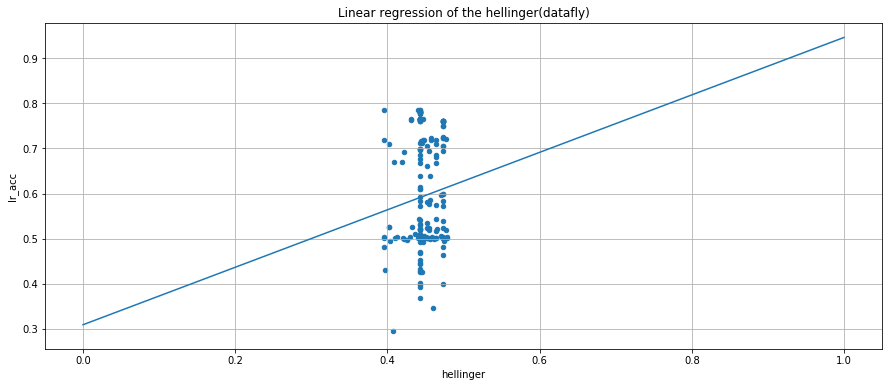

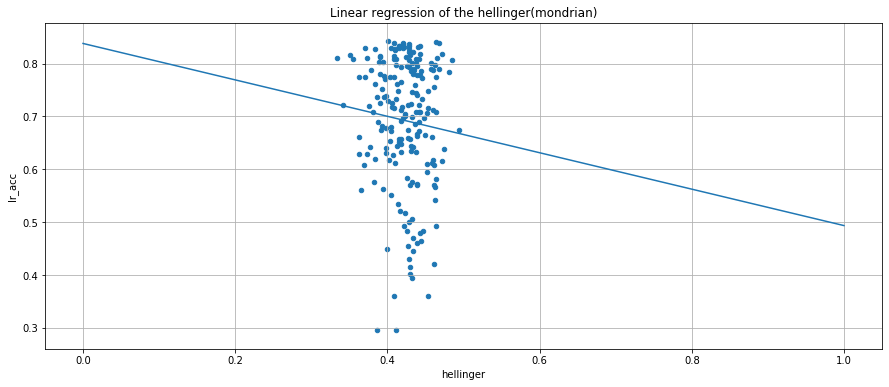

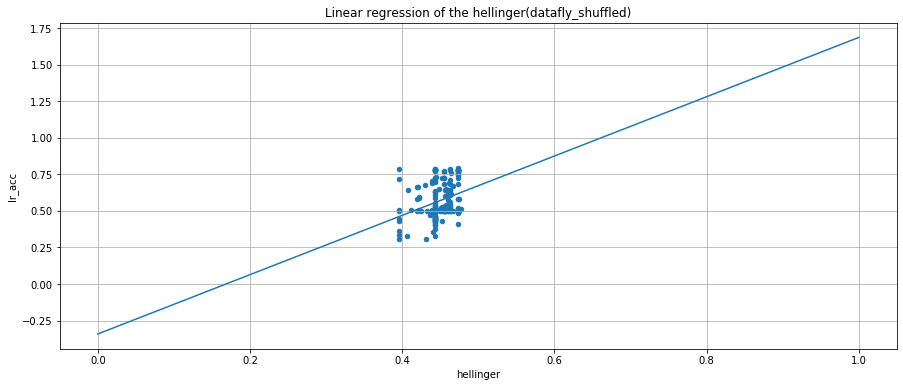

In [28]:
fit_and_graph("hellinger", dataf)
print()
fit_and_graph("hellinger", mondr)
print()
fit_and_graph("hellinger", dataf_shuff)

### Multiple Metrics

In [30]:
metrics = ["entropy", "cm", "dm", "precision", "discern", "ilm", "hellinger"]

res = []
for i in range(1,6):
    
    for comb in itertools.combinations(metrics, i):
        
        ms = list(comb)
        for alg in [mondr, dataf_shuff, dataf]:
            name = alg["algo"].iloc[0] 
            reg, score = regress(ms, alg)
            err = mse(reg, ms)
            p_val = scipy.stats.pearsonr(alg[ms[0]], alg['lr_acc'])[1] if i == 1 else None
            res.append((str(ms), name, p_val, score, err))

            
df = pd.DataFrame(res, columns=["metrics", "algo", "p_value", "R2_score", "MSE_error"])
df = df.set_index(["metrics", "algo"])
df.head(25)

p_value  R2_score  MSE_error
metrics           algo                                               
['entropy']       mondrian          1.852661e-02  0.027688   0.069569
                  datafly_shuffled  2.661046e-03  0.044674   0.066904
                  datafly           5.811058e-03  0.037788   0.054248
['cm']            mondrian          1.631712e-02  0.028784   0.014894
                  datafly_shuffled  2.399774e-25  0.421842   0.050274
                  datafly           1.667978e-26  0.437107   0.084407
['dm']            mondrian          1.119302e-01  0.012712   0.037243
                  datafly_shuffled  2.623016e-01  0.006342   0.065518
                  datafly           4.919720e-01  0.002388   0.039534
['precision']     mondrian          2.575028e-02  0.024864   0.018226
                  datafly_shuffled  1.645092e-04  0.069366   0.104584
                  datafly           3.549005e-01  0.004324   0.028100
['discern']       mondrian          1.878617e-01  0.008743  98.970222
                  datafly_shuffled  7.751556e-04  0.055607   0.027640
                  datafly           1.976452e-03  0.047306   0.023921
['ilm']           mondrian          9.028950e-03  0.033928   0.015777
                  datafly_shuffled  1.169029e-02  0.031676   0.032048
                  datafly           1.934466e-01  0.008526   0.015876
['hellinger']     mondrian          2.572246e-01  0.006478   0.022304
                  datafly_shuffled  1.305989e-05  0.091726   0.026898
                  datafly           1.800326e-01  0.009059   0.019487
['entropy', 'cm'] mondrian                   NaN  0.033136   0.044197
                  datafly_shuffled           NaN  0.423602   0.068169
                  datafly                    NaN  0.441157   0.058204
['entropy', 'dm'] mondrian                   NaN  0.031849   0.127616